## Model Training

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [214]:
df = pd.read_csv("../data/processed/nhanes_data_processed.csv")

### Split the dataset into training, cross validation and test sets

The dataset will be split into three parts:
- 60% training set - to train the model
- 20% cross validation set - to evaluate the different model configurations
- 20% test set - to give a fair estimate of the chosen model's performance against new examples

In [215]:
x = df[["bmi", "high_blood_pressure", "age", "hba1c_percentage", "fpg_mmol_L", "hdl_mmol_L", "lifetime_100_cigs_smoked", "current_smoking_freq"]]
y = df[["diabetes"]]

In [216]:
from sklearn.model_selection import train_test_split

x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.4, random_state=42, stratify=y)

x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.5, random_state=42, stratify=y_)

del x_, y_

print(f"Shape of training set input: {x_train.shape}")
print(f"Shape of training set target: {y_train.shape}\n")
print(f"Shape of cross validation set input: {x_cv.shape}")
print(f"Shape of cross validation set target: {y_cv.shape}\n")
print(f"Shape of test set input: {x_test.shape}")
print(f"Shapre of test set target: {y_test.shape}")


Shape of training set input: (672, 8)
Shape of training set target: (672, 1)

Shape of cross validation set input: (224, 8)
Shape of cross validation set target: (224, 1)

Shape of test set input: (224, 8)
Shapre of test set target: (224, 1)


### Feature scaling using Z-score normalisation

In [217]:
df.describe()

,bmi,high_blood_pressure,gender,age,diabetes,hba1c_percentage,fpg_mmol_L,hdl_mmol_L,lifetime_100_cigs_smoked,current_smoking_freq
count,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.0,1120.000000
mean,29.489464,0.433929,0.533036,57.150000,1.909821,5.687054,5.877232,1.382071,1.0,2.443750
std,6.357229,0.495837,0.499130,15.654297,0.414108,0.685300,0.982701,0.359415,0.0,0.857317
min,16.400000,0.000000,0.000000,18.000000,1.000000,3.200000,3.550000,0.590000,1.0,1.000000
25%,24.900000,0.000000,0.000000,44.000000,2.000000,5.300000,5.270000,1.110000,1.0,2.000000
50%,28.600000,0.000000,1.000000,61.000000,2.000000,5.600000,5.660000,1.320000,1.0,3.000000
75%,33.100000,1.000000,1.000000,69.000000,2.000000,5.900000,6.160000,1.580000,1.0,3.000000
max,50.400000,1.000000,1.000000,80.000000,3.000000,9.300000,9.940000,2.590000,1.0,3.000000


In [218]:
from sklearn.preprocessing import StandardScaler

vars_to_scale = ["bmi", "age", "hba1c_percentage", "fpg_mmol_L", "hdl_mmol_L"]

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train[vars_to_scale])

x_cv = scaler.transform(x_cv[vars_to_scale])
x_test = scaler.transform(x_test[vars_to_scale])

## Training a decision tree model

In [219]:
# Create a list of hyperparameters to observe their effects on model performance

min_samples_split_list = [2, 10, 25, 50, 100, 200, 300, 500]
max_depth_list = [1, 2, 4, 8, 16, 32, 64, None]
RANDOM_STATE = 42

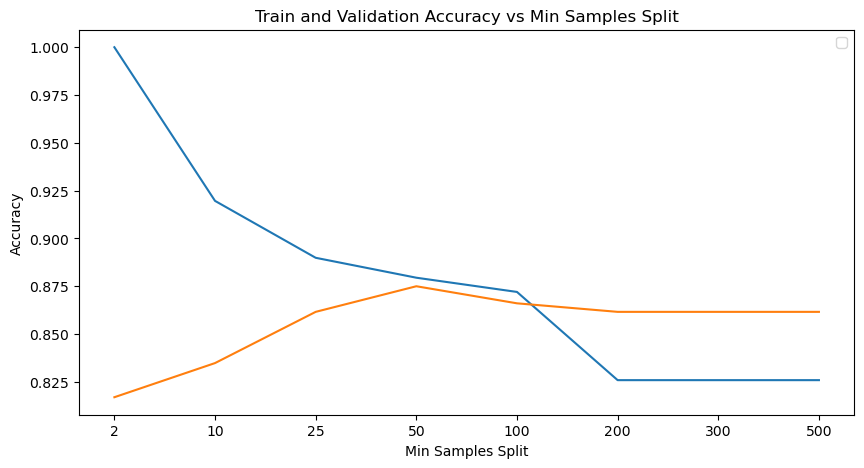

In [220]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

accuracy_list_train = []
accuracy_list_cv = []

for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(criterion="entropy", 
                                    min_samples_split=min_samples_split,
                                    random_state=RANDOM_STATE).fit(x_train_scaled, y_train)
    
    # Predict on training and cross-validation sets
    pred_train = model.predict(x_train_scaled)
    pred_cv = model.predict(x_cv)
    
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_cv = accuracy_score(y_cv, pred_cv)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_cv.append(accuracy_cv)

plt.figure(figsize=(10, 5))
plt.title("Train and Validation Accuracy vs Min Samples Split")
plt.xlabel("Min Samples Split")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_cv)
plt.show()

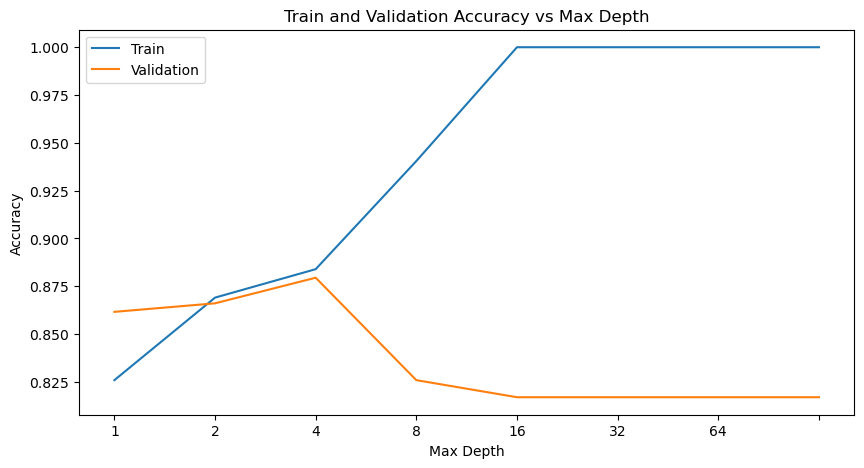

In [221]:
accuracy_list_train = []
accuracy_list_cv = []

for max_depth in max_depth_list:
    model = DecisionTreeClassifier(criterion="entropy",
                                    max_depth=max_depth,
                                    random_state=RANDOM_STATE).fit(x_train_scaled, y_train)
    
    pred_train = model.predict(x_train_scaled)
    pred_cv = model.predict(x_cv)
    
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_cv = accuracy_score(y_cv, pred_cv)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_cv.append(accuracy_cv)
    
plt.figure(figsize=(10,5))
plt.title("Train and Validation Accuracy vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_cv)
plt.legend(["Train", "Validation"])
plt.show()

In [ ]:
decision_tree_model = DecisionTreeClassifier(criterion="entropy",
                                                min_samples_split=50,
                                                max_depth=4,
                                                random_state=RANDOM_STATE)
decision_tree_model.fit(x_train_scaled, y_train)

pred_train = decision_tree_model.predict(x_train_scaled)
pred_cv = decision_tree_model.predict(x_cv)

accuracy_train = accuracy_score(y_train, pred_train)
accuracy_cv = accuracy_score(y_cv, pred_cv)

print(f"Accuracy score of training set: {accuracy_train}")
print(f"Accuracy score of validation set: {accuracy_cv}")
print(f"Difference in accuracy: {accuracy_train - accuracy_cv}")

Accuracy score of training set: 0.8794642857142857
Accuracy score of validation set: 0.8794642857142857
Difference in accuracy: 0.0


In [223]:
pred_test = decision_tree_model.predict(x_test)
pred_test

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2], dtype=int64)

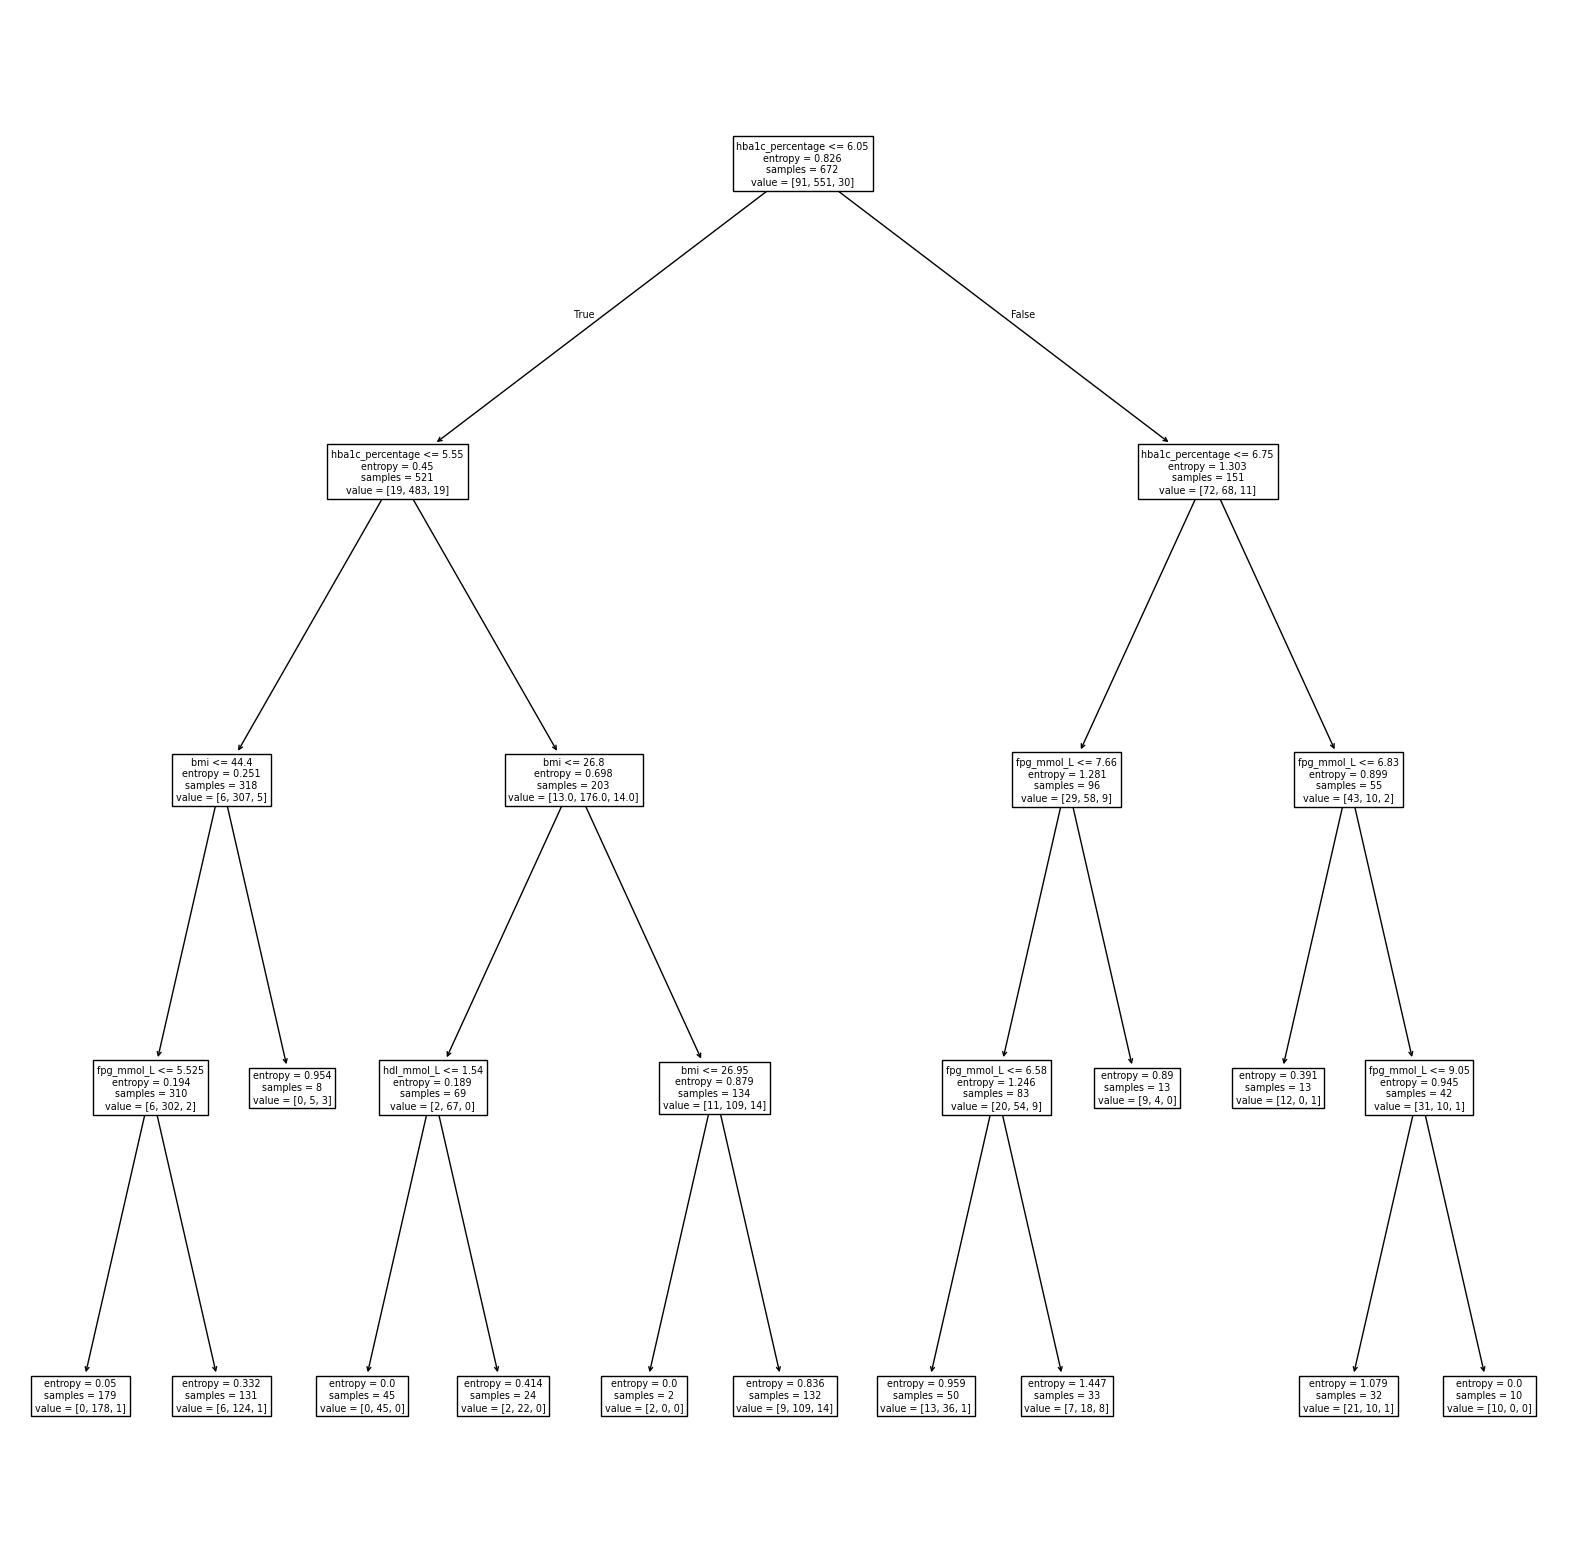

In [224]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(decision_tree_model.fit(x_train, y_train), feature_names=x_train.columns)
plt.show()

In [225]:
decision_tree_model.classes_

array([1, 2, 3], dtype=int64)

### Confusion Matrix and Classfication Report

In [226]:
from sklearn.metrics import confusion_matrix

cnf_matrix_test = confusion_matrix(y_test, pred_test, labels=decision_tree_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,19,11,0
Diabetes_no_actual,4,180,0
Diabetes_borderline_actual,1,9,0


In [227]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_test, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"]))

                     precision    recall  f1-score   support

       Diabetes_yes       0.79      0.63      0.70        30
        Diabetes_no       0.90      0.98      0.94       184
Diabetes_borderline       0.00      0.00      0.00        10

           accuracy                           0.89       224
          macro avg       0.56      0.54      0.55       224
       weighted avg       0.85      0.89      0.86       224



c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [228]:
y_train.value_counts()

diabetes
2           551
1            91
3            30
Name: count, dtype: int64